In [1]:
import torch
from audiocraft.models.musicgen import MusicGen
from audiocraft.modules.conditioners import ChromaChordConditioner
from audiocraft.solvers.compression import CompressionSolver
import math
from pathlib import Path

/home/sake/.local/share/virtualenvs/MusicGen_Chord-oUf8QcxV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded = torch.load("/home/sake/musicgen/MusicGen_Chord/musicgen_chord.th")
# loaded = torch.load("/mnt/nvme/tmp/audiocraft_sake/xps/ad674726/checkpoint.th")

In [3]:
# from sys import getsizeof
# [x for x in loaded['model'].keys()]

In [4]:
# len([x for x in loaded['model'].values()])

In [5]:
# [x.shape for x in loaded['best_state']['model'].values()]

In [3]:
from audiocraft.models.builders import get_lm_model, get_compression_model, get_wrapped_compression_model
from omegaconf import OmegaConf

def _delete_param(cfg, full_name: str):
    parts = full_name.split('.')
    for part in parts[:-1]:
        if part in cfg:
            cfg = cfg[part]
        else:
            return
    OmegaConf.set_struct(cfg, False)
    if parts[-1] in cfg:
        del cfg[parts[-1]]
    OmegaConf.set_struct(cfg, True)

device = 'cuda'

In [4]:
# LM

cfg = OmegaConf.create(loaded['xp.cfg'])
cfg.device = str(device)
if cfg.device == 'cpu':
    cfg.dtype = 'float32'
else:
    cfg.dtype = 'float16'
_delete_param(cfg, 'conditioners.self_wav.chroma_chord.cache_path')
_delete_param(cfg, 'conditioners.self_wav.chroma_stem.cache_path')
_delete_param(cfg, 'conditioners.args.merge_text_conditions_p')
_delete_param(cfg, 'conditioners.args.drop_desc_p')

lm = get_lm_model(loaded['xp.cfg'])
lm.load_state_dict(loaded['best_state']['model']) 
lm.eval()
lm.cfg = cfg

In [5]:
compression_model = CompressionSolver.wrapped_model_from_checkpoint(cfg, cfg.compression_model_checkpoint, device=device)

In [6]:
model = MusicGen("sakemin/musicgen-chord", compression_model, lm)

In [7]:
model.set_generation_params(duration=30)
model.lm = model.lm.to('cuda')

# Generate with Chord text

In [8]:
target_path = Path("/home/sake/chords_text_gen")

In [9]:
descriptions = ["piano song"]
chord_text = 'C G E:min A:min'
bpm = 120
in_triple = False

for i in range(len(descriptions)):
    if in_triple:
        descriptions[i] = descriptions[i] + ", in triple"
    descriptions[i] = descriptions[i] + f", bpm : {bpm}"

In [10]:
from audiocraft.data.audio import audio_write
import torchaudio
from tqdm import tqdm

In [11]:
chord_text.split(' ')

['C', 'G', 'E:min', 'A:min']

In [13]:
import IPython.display as ipd

In [12]:
path = target_path/descriptions[0]/str(chord_text)
for i in tqdm(range(1)): 
    # print(descriptions)
    # wav = model.generate(descriptions)  # generates 3 samples.

    wav = model.generate_with_text_chroma(descriptions, chord_text, bpm = bpm, in_triple = in_triple)

    for idx, one_wav in enumerate(wav):
        # Will save under {idx}.wav, with loudness normalization at -14 db LUFS.
        path.mkdir(parents=True, exist_ok=True)
        ipd.display(ipd.Audio(one_wav.cpu(), rate = 32000))
        audio_write(f'{str(path/str(i))}_{i}', one_wav.cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

  0%|          | 0/1 [00:37<?, ?it/s]


NameError: name 'ipd' is not defined

# Detect the chords of the output

In [44]:
import pretty_midi as pm
from audiocraft.modules.btc.utils.chords import Chords
import matplotlib.pyplot as plt
chordreader = Chords()

In [254]:
import os
from audiocraft.modules.btc import mir_eval
from audiocraft.modules.btc.utils import logger
from audiocraft.modules.btc.btc_model import *
from audiocraft.modules.btc.utils.mir_eval_modules import audio_file_to_features, idx2chord, idx2voca_chord, get_audio_paths
import argparse
import warnings

warnings.filterwarnings('ignore')
logger.logging_verbosity(1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

config = HParams.load("/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/run_config.yaml")

config.feature['large_voca'] = True
config.model['num_chords'] = 170
model_file = '/home/sake/musicgen/MusicGen_Chord/audiocraft/modules/btc/test/btc_model_large_voca.pt'
idx_to_chord = idx2voca_chord()

btcmodel = BTC_model(config=config.model).to(device)

# Load model
if os.path.isfile(model_file):
    checkpoint = torch.load(model_file)
    mean = checkpoint['mean']
    std = checkpoint['std']
    btcmodel.load_state_dict(checkpoint['model'])
    logger.info("restore model")

save_paths = []
for path in paths:
    # Audio files with format of wav and mp3
    audio_paths = get_audio_paths(path)
    # Chord recognition and save lab file
    for i, audio_path in enumerate(audio_paths):
        logger.info("======== %d of %d in progress ========" % (i + 1, len(audio_paths)))
        # Load mp3
        feature, feature_per_second, song_length_second = audio_file_to_features(audio_path, config)
        logger.info("audio file loaded and feature computation success : %s" % audio_path)

        # Majmin type chord recognition
        feature = feature.T
        feature = (feature - mean) / std
        time_unit = feature_per_second
        n_timestep = config.model['timestep']

        num_pad = n_timestep - (feature.shape[0] % n_timestep)
        feature = np.pad(feature, ((0, num_pad), (0, 0)), mode="constant", constant_values=0)
        num_instance = feature.shape[0] // n_timestep

        start_time = 0.0
        lines = []
        with torch.no_grad():
            btcmodel.eval()
            feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
            for t in range(num_instance):
                self_attn_output, _ = btcmodel.self_attn_layers(feature[:, n_timestep * t:n_timestep * (t + 1), :])
                prediction, _ = btcmodel.output_layer(self_attn_output)
                prediction = prediction.squeeze()
                for i in range(n_timestep):
                    if t == 0 and i == 0:
                        prev_chord = prediction[i].item()
                        continue
                    if prediction[i].item() != prev_chord:
                        lines.append(
                            '%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                        start_time = time_unit * (n_timestep * t + i)
                        prev_chord = prediction[i].item()
                    if t == num_instance - 1 and i + num_pad == n_timestep:
                        if start_time != time_unit * (n_timestep * t + i):
                            lines.append('%.3f %.3f %s\n' % (start_time, time_unit * (n_timestep * t + i), idx_to_chord[prev_chord]))
                        break

        # lab file write
        if not os.path.exists(path):
            os.makedirs(path)
        save_path = os.path.join(path, os.path.split(audio_path)[-1].replace('.mp3', '').replace('.wav', '') + '.lab')
        save_paths.append(save_path)
        with open(save_path, 'w') as f:
            for line in lines:
                f.write(line)

        logger.info("label file saved : %s" % save_path)

        # lab file to midi file
        

        starts, ends, pitchs = list(), list(), list()

        intervals, chords = mir_eval.io.load_labeled_intervals(save_path)
        for p in range(12):
            for i, (interval, chord) in enumerate(zip(intervals, chords)):
                root_num, relative_bitmap, _ = mir_eval.chord.encode(chord)
                tmp_label = mir_eval.chord.rotate_bitmap_to_root(relative_bitmap, root_num)[p]
                if i == 0:
                    start_time = interval[0]
                    label = tmp_label
                    continue
                if tmp_label != label:
                    if label == 1.0:
                        starts.append(start_time), ends.append(interval[0]), pitchs.append(p + 48)
                    start_time = interval[0]
                    label = tmp_label
                if i == (len(intervals) - 1): 
                    if label == 1.0:
                        starts.append(start_time), ends.append(interval[1]), pitchs.append(p + 48)

        midi = pm.PrettyMIDI()
        instrument = pm.Instrument(program=0)

        for start, end, pitch in zip(starts, ends, pitchs):
            pm_note = pm.Note(velocity=120, pitch=pitch, start=start, end=end)
            instrument.notes.append(pm_note)

        midi.instruments.append(instrument)
        midi.write(save_path.replace('.lab', '.midi'))    



I MusicGen_Chord 09-27 18:07:12.366 2938163164.py:29] restore model
I MusicGen_Chord 09-27 18:07:12.368 2938163164.py:37] ======== 1 of 2 in progress ========
I MusicGen_Chord 09-27 18:07:12.511 2938163164.py:40] audio file loaded and feature computation success : /home/sake/chords_wav_gen/piano_song/psycho.wav
I MusicGen_Chord 09-27 18:07:12.587 2938163164.py:84] label file saved : /home/sake/chords_wav_gen/piano_song/psycho.lab
I MusicGen_Chord 09-27 18:07:12.593 2938163164.py:37] ======== 2 of 2 in progress ========
I MusicGen_Chord 09-27 18:07:12.733 2938163164.py:40] audio file loaded and feature computation success : /home/sake/chords_wav_gen/piano_song/Ditto-2-NewJeans.wav
I MusicGen_Chord 09-27 18:07:12.794 2938163164.py:84] label file saved : /home/sake/chords_wav_gen/piano_song/Ditto-2-NewJeans.lab
I MusicGen_Chord 09-27 18:07:12.803 2938163164.py:37] ======== 1 of 1 in progress ========
I MusicGen_Chord 09-27 18:07:12.938 2938163164.py:40] audio file loaded and feature compu

In [255]:
save_paths

['/home/sake/chords_wav_gen/piano_song/psycho.lab',
 '/home/sake/chords_wav_gen/piano_song/Ditto-2-NewJeans.lab',
 '/home/sake/chords_wav_gen/heavy_metal/Ditto-2-NewJeans.lab',
 '/home/sake/chords_wav_gen/70s_jazz/Ditto-2-NewJeans.lab',
 '/home/sake/chords_wav_gen/chill_hip_hop/Ditto-2-NewJeans.lab',
 '/home/sake/chords_wav_gen/melodic_house_dance_music/psycho.lab',
 '/home/sake/chords_wav_gen/melodic_house_dance_music/Ditto-2-NewJeans.lab',
 '/home/sake/chords_wav_gen/noise_music/Ditto-2-NewJeans.lab']

In [256]:
crds = []
for save_path in save_paths:
    crd = chordreader.load_chords(save_path)
    crds.append(crd)

In [257]:
timebin = 30/235
chromas = []
for ccrd in crds:
    chroma = torch.zeros([235,12])
    count = 0
    for crd in ccrd:
        if count >= 235:
            break
        if crd[2][0] == -1:
            multihot = torch.Tensor(crd[2][2])
        else:
            multihot = torch.concat([torch.Tensor(crd[2][2])[-crd[2][0]:],torch.Tensor(crd[2][2])[:-crd[2][0]]])
        start_bin = round(crd[0]/timebin)
        end_bin = round(crd[1]/timebin)
        for j in range(start_bin,end_bin):
            if count >= 235: 
                break
            chroma[j]=multihot
            count += 1
    chromas.append(chroma)

In [259]:
chromas.pop(5)
chromas.pop(0)
len(chromas)

6

piano song


heavy metal


70s jazz


chill hip hop


melodic house dance music


noise music


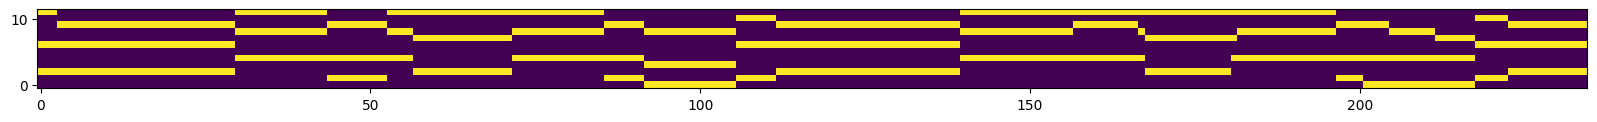

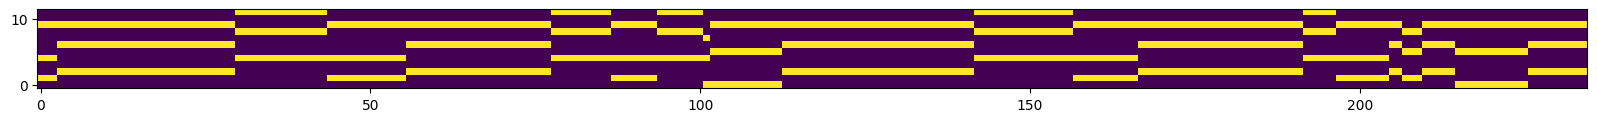

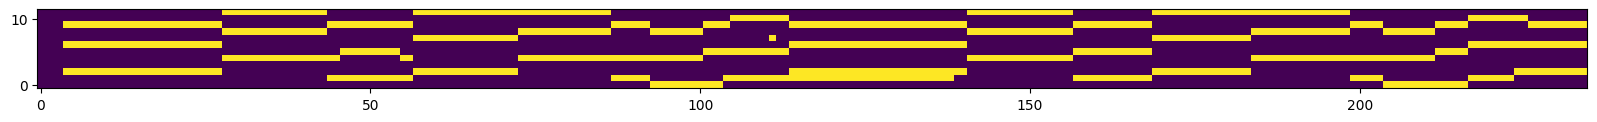

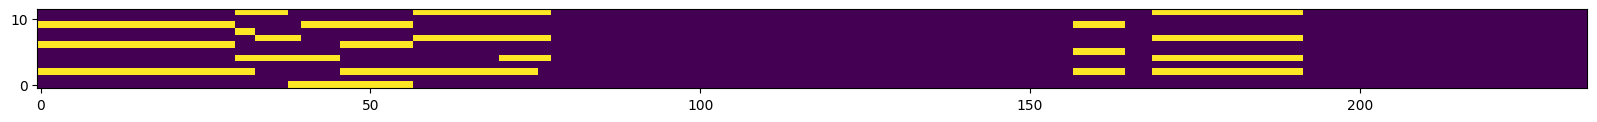

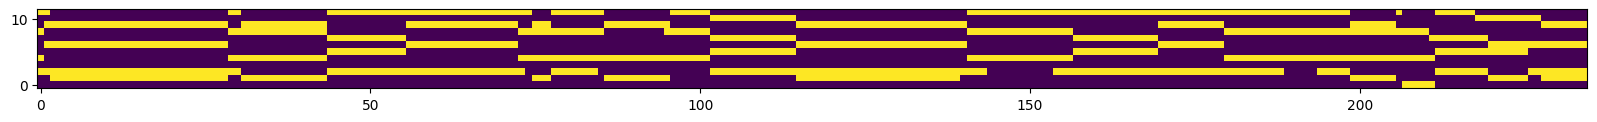

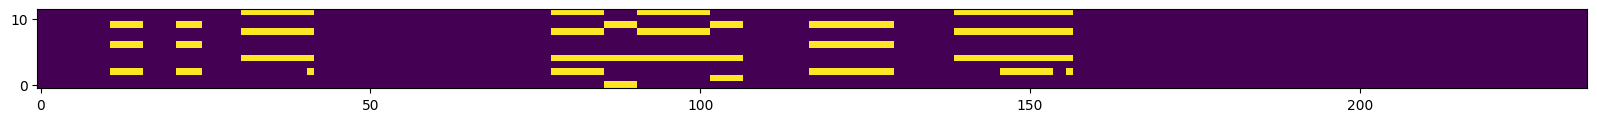

: 

In [260]:
for i, chroma in enumerate(chromas):
    plt.figure(figsize = (20,2))
    print(descriptions[i])
    display(plt.imshow(chroma.T, origin='lower', interpolation='nearest'))
    plt.savefig(save_paths[i].replace('.lab', '.png'))

In [183]:
chroma_len = 235
n_chroma = 12

sample_rate = 32000
hop_size = 4096

bar2chromabin = sample_rate/hop_size
bpm_div = 3 if in_triple else 4

barsec = 60/(bpm/bpm_div)

timebin = barsec * bar2chromabin
rounded_timebin = round(timebin)

stext = chord_text.split(" ")

og_chroma = torch.zeros([chroma_len, n_chroma])
count = 0
offset = 0

while count < chroma_len:
    for tokens in stext:
        if count >= chroma_len: 
            break
        stoken = tokens.split(',')
        for token in stoken:
            off_timebin = timebin + offset
            rounded_timebin = round(off_timebin)
            offset = off_timebin - rounded_timebin
            offset = offset/len(stoken)
            add_step = rounded_timebin//len(stoken)
            mhot = chordreader.chord(token)
            rolled = np.roll(mhot[2], mhot[0])
            for i in range(count, count + add_step):
                if count >= chroma_len: 
                    break
                og_chroma[i] = torch.Tensor(rolled)
                count += 1
og_chroma[-15:], og_chroma.shape, count

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([235, 12]),
 235)

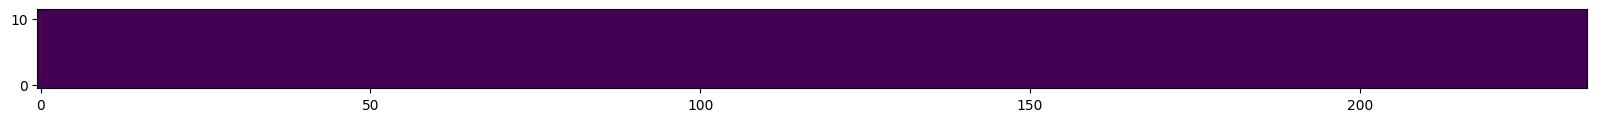

In [184]:
plt.figure(figsize = (20,2))
plt.imshow(og_chroma.T, origin='lower', interpolation='nearest')
plt.savefig(save_path.replace('.lab', '.png'))

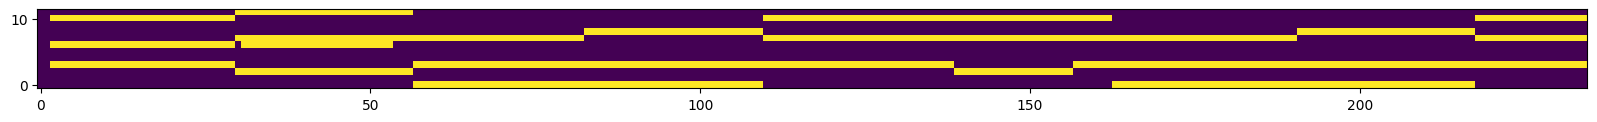

In [185]:
plt.figure(figsize = (20,2))
plt.imshow(chroma.T, origin='lower', interpolation='nearest')
plt.savefig(save_path.replace('.lab', '.png'))

In [69]:
import IPython.display as ipd
ipd.Audio(save_path.replace('.lab', '.wav'))

In [70]:
chord_text

'N'

In [57]:
chords

['G#',
 'D#',
 'G',
 'C',
 'C:min',
 'G#',
 'G#:min',
 'G#',
 'A#',
 'A#:sus4',
 'D#',
 'A#',
 'C:min',
 'G#',
 'A#',
 'A#:sus4']

# Generate with wav

In [8]:
from pathlib import Path

In [9]:
target_path = Path("/home/sake/chords_wav_gen")

In [10]:
descriptions = []

In [11]:
descriptions.append('eurovision dance music')
# descriptions.append('heavy metal')
# descriptions.append('70s jazz')
# descriptions.append('chill hip hop')
# descriptions.append('melodic house dance music')
# descriptions.append('noise music')

In [12]:
input_wav_path = '/home/sake/psycho/psycho.mp3'

In [13]:
ppath = []
for i in range(len(descriptions)):
    ppath.append(target_path/descriptions[i].replace(' ', '_')/str(Path(input_wav_path).name).rsplit('.', 1)[0])
ppath

[PosixPath('/home/sake/chords_wav_gen/eurovision_dance_music/psycho')]

In [14]:
paths = [p_path.parent for p_path in ppath]
paths

[PosixPath('/home/sake/chords_wav_gen/eurovision_dance_music')]

In [15]:
import torchaudio

In [16]:
melody, sr = torchaudio.load(input_wav_path)

In [17]:
wav = model.generate_with_chroma(descriptions, melody[None].expand(len(descriptions), -1, -1).to('cuda'), sr)

/home/sake/.local/share/virtualenvs/MusicGen_Chord-oUf8QcxV/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=413
  warnings.warn(
/home/sake/.local/share/virtualenvs/MusicGen_Chord-oUf8QcxV/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=207
  warnings.warn(


In [18]:
# wav = model.generate_with_chroma(descriptions, [None], sr)

In [19]:
import IPython.display as ipd
for i, wwav in enumerate(wav):
    print(descriptions[i])
    ipd.display(ipd.Audio(wwav.cpu(), rate = 32000))
    audio_write(ppath[i], wwav.cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

eurovision dance music


NameError: name 'audio_write' is not defined

In [173]:
# audio_write(ppath, wav.squeeze().cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

PosixPath('/home/sake/chords_wav_gen/dnb,_drum_and_bass/psycho.wav')

# Replace back to melodymodel

In [74]:
from audiocraft.modules.conditioners import ChromaStemConditioner
import math

In [72]:
melmodel = MusicGen.get_pretrained('facebook/musicgen-melody')

In [77]:
output_proj_weight = melmodel.lm.condition_provider.conditioners['self_wav'].output_proj.state_dict()

In [90]:
model.lm.condition_provider.conditioners['self_wav'] = ChromaStemConditioner(int(melmodel.lm.condition_provider.conditioners['self_wav'].output_dim), int(melmodel.lm.condition_provider.conditioners['self_wav'].sample_rate), int(melmodel.lm.condition_provider.conditioners['self_wav'].chroma.n_chroma), int(math.log2(melmodel.lm.condition_provider.conditioners['self_wav'].chroma.winlen)), float(melmodel.lm.condition_provider.conditioners['self_wav'].duration), device='cuda')

In [91]:
model.lm.condition_provider.conditioners['self_wav'].output_proj.load_state_dict(output_proj_weight)

<All keys matched successfully>

In [ ]:
model.lm.to('cuda')

In [80]:
import torchaudio

In [95]:
melody, sr = torchaudio.load('/home/sake/psycho_midi_single_track_ep_2.wav')

In [113]:
wav = model.generate_with_chroma(['piano song'], melody[None].expand(1, -1, -1).to('cuda'), sr)

In [114]:
import IPython.display as ipd
ipd.Audio(wav.squeeze().cpu(), rate = 32000)

In [105]:
audio_write('/home/sake/melodyrollbacktest', wav.squeeze().cpu(), model.sample_rate, strategy="loudness", loudness_compressor=True)

PosixPath('/home/sake/melodyrollbacktest.wav')

In [115]:
model.lm.cfg_dropout.p = 0.5

In [131]:
model.lm.att_dropout.p['wav']['self_wav'] = 1.0

___

In [ ]:
import numpy as np

In [ ]:
mhot = chordreader.chord("A:min")
mhot

In [ ]:
mhot.shape

In [ ]:
rolled = np.roll(mhot[2], mhot[0])

In [ ]:
loaded['xp.cfg']

In [ ]:
loaded['compression_model']

In [ ]:
model.lm.load_state_dict(loaded['best_state'])
model.lm.to('cuda')

In [ ]:
target_path = Path("/home/sake/chords_text_gen")

In [ ]:
loaded.keys()

In [ ]:
loaded['optimizer']

In [ ]:
loaded['fsdp_best_state']

In [ ]:
loaded['model']

In [ ]:
loaded['model']['condition_provider.conditioners.self_wav.output_proj.weight'].shape

In [242]:
model.lm.condition_provider.conditioners.self_wav

ChromaChordConditioner(
  (output_proj): Linear(in_features=12, out_features=1536, bias=True)
  (chroma): ChordExtractor(
    (model): BTC_model(
      (self_attn_layers): bi_directional_self_attention_layers(
        (embedding_proj): Linear(in_features=144, out_features=128, bias=False)
        (self_attn_layers): Sequential(
          (0): bi_directional_self_attention(
            (attn_block): self_attention_block(
              (multi_head_attention): MultiHeadAttention(
                (query_linear): Linear(in_features=128, out_features=128, bias=False)
                (key_linear): Linear(in_features=128, out_features=128, bias=False)
                (value_linear): Linear(in_features=128, out_features=128, bias=False)
                (output_linear): Linear(in_features=128, out_features=128, bias=False)
                (dropout): Dropout(p=0.2, inplace=False)
              )
              (positionwise_convolution): PositionwiseFeedForward(
                (layers): ModuleLis